In [1]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import networkx as nx
import sklearn
import sklearn.metrics
import time

import gconcorde as cce

In [2]:
def get_precision(X):
    return .5*(np.diag(np.diag(X)) @ X) + .5*(X.T @ np.diag(np.diag(X)))

def mcc(B, B_hat, diag=False):
    """
    Compute Matthew's Correlation Coefficient (MCC) between two matrices.
    If diag=False, it excludes diagonal elements before computing MCC.
    """
    
    B_vec = B.ravel()
    B_hat_vec = B_hat.ravel()
    
    if diag:
        return sklearn.metrics.matthews_corrcoef(B_vec, B_hat_vec)

    p = len(B)
    indx = np.arange(0, p**2, p+1)
    B_vec = np.where(B_vec != 0, 1, 0)
    B_vec = np.delete(B_vec, indx)
    B_hat_vec = np.where(B_hat_vec != 0, 1, 0)
    B_hat_vec = np.delete(B_hat_vec, indx)
    
    return sklearn.metrics.matthews_corrcoef(B_vec, B_hat_vec)

def standardize(X, bias=False):
    X_std = X.copy()
    X_std -= X_std.mean(axis=0)
    if bias:
        X_std /= X_std.std(axis=0)
    else:
        X_std /= X_std.std(axis=0, ddof=1)
    
    return X_std

def omega_to_corr(A):
    std_inv = np.diag(np.sqrt(1/np.diag(A)))
    A_corr = -1 * (std_inv @ A @ std_inv)
    np.fill_diagonal(A_corr, 1)
    
    return A_corr

In [3]:
# erdos-renyi

# number of variables
p = 300
# number of datasets
N = 1
# n = n_prop_to_p * p
n_prop_to_p = [0.5]
edge_prob = 0.05
random_state = 2022
lower_weight, upper_weight = 0.5, 1.0
spread_diag=[1, np.sqrt(3)]
G = nx.generators.random_graphs.erdos_renyi_graph(n=p, p=edge_prob, seed=random_state)
Skel = nx.to_numpy_matrix(G)

# Peng's method (ensuring positive definiteness of precision matrix)
np.random.seed(random_state)
edge_weights = np.random.uniform(low=lower_weight, high=upper_weight, size=(p,p))
edge_signs = np.random.choice([-1,1], size=(p,p))
Omega = np.multiply(edge_weights, edge_signs)
Omega = np.multiply(Skel, Omega)
Omega = np.tril(Omega) + np.tril(Omega).T
np.fill_diagonal(Omega, 1.5*np.abs(Omega).sum(1))
diag_inv = np.diag(1/np.sqrt(np.diag(Omega)))
Omega = diag_inv @ Omega @ diag_inv

# spread diagonal of precision matrix
d = np.random.uniform(spread_diag[0], spread_diag[1], p)
Omega = np.diag(d) @ Omega @ np.diag(d)
Cov = np.linalg.inv(Omega)
Omega_corr = omega_to_corr(Omega)

# generate Gaussian data
Xs = []
for this in n_prop_to_p:
    for j in range(N):
        rs = np.random.RandomState(random_state)
        X = rs.multivariate_normal(mean=np.zeros(p), cov=Cov, size=int(this*p))
        X_std = standardize(X, bias=False)
        Xs.append(X_std)
        random_state += 1
        
# choose length of grid for lambda
num_lams = 10

In [4]:
S = np.cov(Xs[0], rowvar=False)

In [6]:
# obtain omega_star for cce_constant
Omega_hat_ccel, hist_ccel = cce.cce_constant(S, 0.1, np.eye(p), epstol=1e-15, maxitr=5000, penalize_diagonal=True)
Omega_star_ccel = Omega_hat_ccel.todense()

In [7]:
Omega_hat_ccel, hist_ccel = cce.cce_constant(S, 0.1, Omega_star_ccel, epstol=1e-15, maxitr=5000, penalize_diagonal=True)
print("hist: (successive norm diff, objective, omega_star norm, iter time)\n %s\n" % (str(hist_ccel[-3:])))
print("total iter count: %d" % (len(hist_ccel)))
print("successive norm diff: %e" % (hist_ccel[-1,0]))
print("objective: %e" % (hist_ccel[-1,1]))
print("omega_star norm: %e" % (hist_ccel[-1,2]))
print("iter time: %e" % (hist_ccel[-1,3]))

hist: (successive norm diff, objective, omega_star norm, iter time)
 [[1.05559028e-15 1.60559346e+02 2.01125010e-15 9.45000000e-04]
 [1.02146198e-15 1.60559346e+02 9.92983356e-16 9.64000000e-04]
 [9.92983356e-16 1.60559346e+02 0.00000000e+00 1.11500000e-03]]

total iter count: 1188
successive norm diff: 9.929834e-16
objective: 1.605593e+02
omega_star norm: 0.000000e+00
iter time: 1.115000e-03


In [8]:
# obtain omega_star for cceista
Omega_hat_cce, hist_cce = cce.cceista(S, 0.1, np.eye(p), epstol=1e-15, maxitr=5000, penalize_diagonal=True)
Omega_star_cce = Omega_hat_cce.todense()

In [9]:
Omega_hat_cce, hist_cce = cce.cceista(S, 0.1, Omega_star_cce, epstol=1e-15, maxitr=5000, penalize_diagonal=True)
print("hist: (inner iter count, successive norm diff, objective, omega_star norm, iter time)\n %s\n" % (str(hist_cce[-3:])))
print("total iter count: %d" % (len(hist_cce)))
print("inner iter: %e" % (hist_cce[-1,0]))
print("successive norm diff: %e" % (hist_cce[-1,1]))
print("objective: %e" % (hist_cce[-1,2]))
print("omega_star norm: %e" % (hist_cce[-1,3]))
print("iter time: %e" % (hist_cce[-1,4]))

hist: (inner iter count, successive norm diff, objective, omega_star norm, iter time)
 [[2.60000000e+01 3.22569448e-15 1.60559346e+02 2.02091191e-15
  3.08259000e-01]
 [2.70000000e+01 1.62186569e-15 1.60559346e+02 4.24262501e-16
  3.24266000e-01]
 [2.90000000e+01 4.24262501e-16 1.60559346e+02 0.00000000e+00
  2.69310000e-01]]

total iter count: 114
inner iter: 2.900000e+01
successive norm diff: 4.242625e-16
objective: 1.605593e+02
omega_star norm: 0.000000e+00
iter time: 2.693100e-01


In [10]:
# fro norm between two omega_stars
np.linalg.norm(Omega_star_ccel - Omega_star_cce)

1.535954729604207e-06

In [11]:
omega_star_norm_ccel = [np.linalg.norm(np.eye(p) - Omega_star_ccel)]
for i in range(len(hist_ccel)):
    omega_star_norm_ccel.append(hist_ccel[i,-2])

omega_star_norm_cce = [np.linalg.norm(np.eye(p) - Omega_star_cce)]
for i in range(len(hist_cce)):
    omega_star_norm_cce.append(hist_cce[i,-2])

In [12]:
time_took_per_iter_ccel = []
for i in range(len(hist_ccel)):
    time_took_per_iter_ccel.append(hist_ccel[i][-1])
time_took_cumsum_ccel = np.cumsum(time_took_per_iter_ccel)
time_took_cumsum_ccel = np.insert(time_took_cumsum_ccel, 0, 0)

time_took_per_iter_cce = []
for i in range(len(hist_cce)):
    time_took_per_iter_cce.append(hist_cce[i][-1])
time_took_cumsum_cce = np.cumsum(time_took_per_iter_cce)
time_took_cumsum_cce = np.insert(time_took_cumsum_cce, 0, 0)

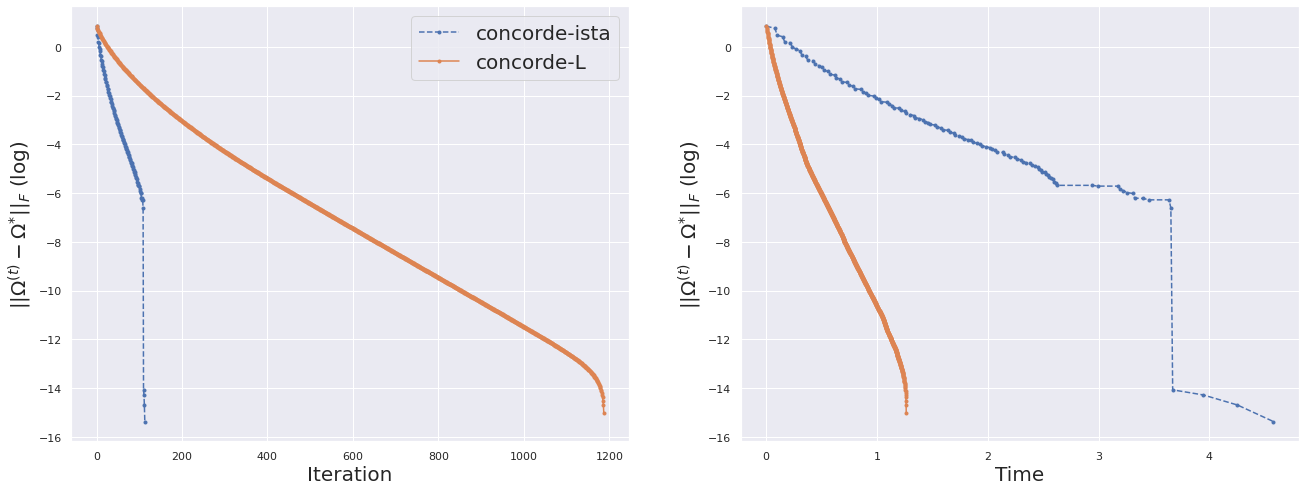

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

for i in range(2):
    if i == 0:
        axes[i].plot(np.arange(len(omega_star_norm_cce)-1), np.log10(omega_star_norm_cce[:-1]), label='concorde-ista', linestyle='--', marker='.')
        axes[i].plot(np.arange(len(omega_star_norm_ccel)-1), np.log10(omega_star_norm_ccel[:-1]), label='concorde-L', marker='.')
        axes[i].legend(fontsize=20, loc='upper right')
        axes[i].set_xlabel('Iteration', fontsize=20)
        axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$ (log)', fontsize=20)
    elif i == 1:
        axes[i].plot(time_took_cumsum_cce[:-1], np.log10(omega_star_norm_cce[:-1]), label='concorde-ista', linestyle='--', marker='.')
        axes[i].plot(time_took_cumsum_ccel[:-1], np.log10(omega_star_norm_ccel[:-1]), label='concorde-L', marker='.')
        axes[i].set_xlabel('Time', fontsize=20)
        axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$ (log)', fontsize=20)
